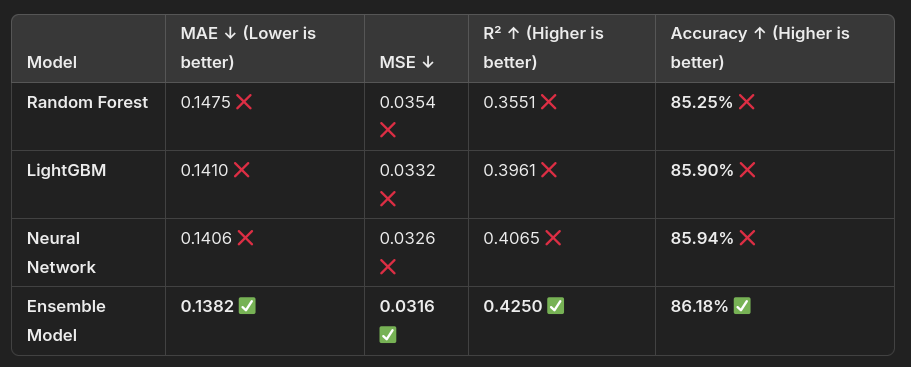

# Dataset


                    description  score emoji
0                 grinning face   1.00     😀
1  smiling face with open mouth   1.00     😃
2                  winking face   1.00     😉
3                    robot face   0.50     🤖
4              father christmas   0.75    🎅🏻


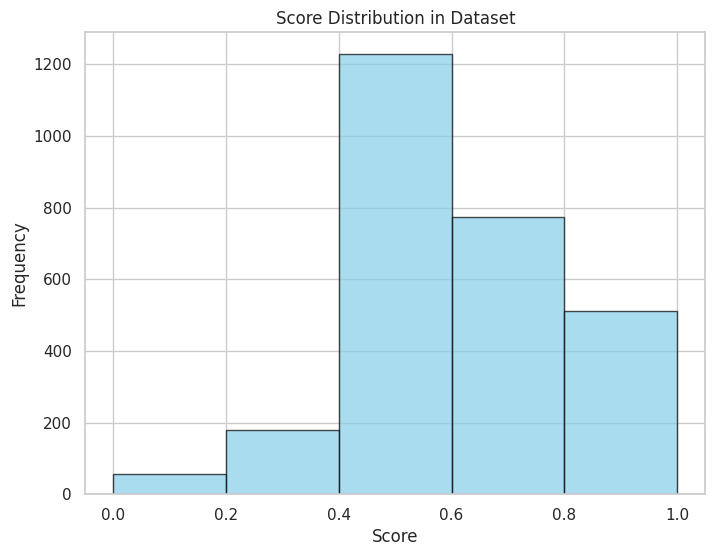

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV data
df = pd.read_csv('dataset/final_data.csv')

# Check the first few rows of the dataset (optional)
print(df.head())

# Plotting the score distribution
plt.figure(figsize=(8, 6))
plt.hist(df['score'], bins=5, edgecolor='black', color='skyblue', alpha=0.7)
plt.title('Score Distribution in Dataset')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)

# Save the plot as an image file
plt.savefig('score_distribution.png')

# Show the plot
plt.show()


In [17]:
# Find range of actual sentiment scores
y_min, y_max = y_test.min(), y_test.max()
range_y = y_max - y_min  # Range of y_test

# Function to compute regression accuracy
def regression_accuracy(mae, range_y):
    return 1 - (mae / range_y)

# MAE values from your models
mae_values = {
    "Random Forest": 0.1475,
    "LightGBM": 0.1410,
    "Neural Network": 0.1406,
    "Ensemble Model": 0.1382
}

# Compute accuracies
accuracies = {model: regression_accuracy(mae, range_y) for model, mae in mae_values.items()}

# Display results
for model, acc in accuracies.items():
    print(f"{model} Accuracy: {acc:.2%}")


Random Forest Accuracy: 85.25%
LightGBM Accuracy: 85.90%
Neural Network Accuracy: 85.94%
Ensemble Model Accuracy: 86.18%


In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

# Load Emoji2Vec model
emoji2vec_model = KeyedVectors.load_word2vec_format("emoji2vec/pre-trained/emoji2vec.bin", binary=True)

# Function to get emoji embeddings
def get_emoji_embedding(emoji):
    try:
        return emoji2vec_model[emoji]
    except KeyError:
        return np.zeros((300,))  # 300D Zero vector for unknown emojis

# Load the full dataset (2700 rows)
df = pd.read_csv("dataset/final_data.csv")  # Change path

# Apply function to convert emojis into embeddings
df["emoji_embedding"] = df["emoji"].apply(get_emoji_embedding)

# Convert to NumPy arrays
X = np.stack(df["emoji_embedding"].values)  # Convert list of arrays to NumPy array
y = df["score"].values  # Sentiment scores

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create PyTorch Dataset & DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [4]:
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))
print("First test emoji embedding shape:", X_test_tensor[0].shape)  # Should be (300,)
print("First test sentiment score:", y_test_tensor[0])


Training samples: 2200
Testing samples: 550
First test emoji embedding shape: torch.Size([300])
First test sentiment score: tensor(0.2500)


# NN MODEL  


In [6]:
class SentimentModel(nn.Module):
    def __init__(self):
        super(SentimentModel, self).__init__()
        self.fc1 = nn.Linear(300, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for regression
        return x


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
import numpy as np

# Load your trained NN model (fix warning)
model = SentimentModel()  # Ensure this matches your saved model architecture
model.load_state_dict(torch.load("model/only_emoji_NN_200.pth", 
                                 map_location=torch.device("cpu"), 
                                 weights_only=True))  # ✅ Fix here
model.eval()  # Set model to evaluation mode

# Lists to store true labels & predictions
y_true, y_pred = [], []

# Disable gradient calculations for inference
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()  # Forward pass
        y_true.extend(y_batch.numpy())  # Store true values
        y_pred.extend(outputs.numpy())  # Store predictions

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print results
print("🔹 NN Model Evaluation:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Create folder for saving graphs if it doesn't exist
output_folder = "evaluation_graphs"
os.makedirs(output_folder, exist_ok=True)

# Function to save graphs
def save_plot(metric_name, value, file_name):
    plt.figure()
    plt.bar(metric_name, value, color='skyblue')
    plt.ylabel('Value')
    plt.title(f'{metric_name} Evaluation')
    plt.savefig(os.path.join(output_folder, file_name))
    plt.close()

# Generate and save graphs for MAE, MSE, and R² Score
save_plot('MAE', mae, 'mae_graph.png')
save_plot('MSE', mse, 'mse_graph.png')
save_plot('R² Score', r2, 'r2_score_graph.png')

print(f"Graphs saved in {output_folder}")


🔹 NN Model Evaluation:
MAE: 0.1406
MSE: 0.0326
R² Score: 0.4065
Graphs saved in evaluation_graphs


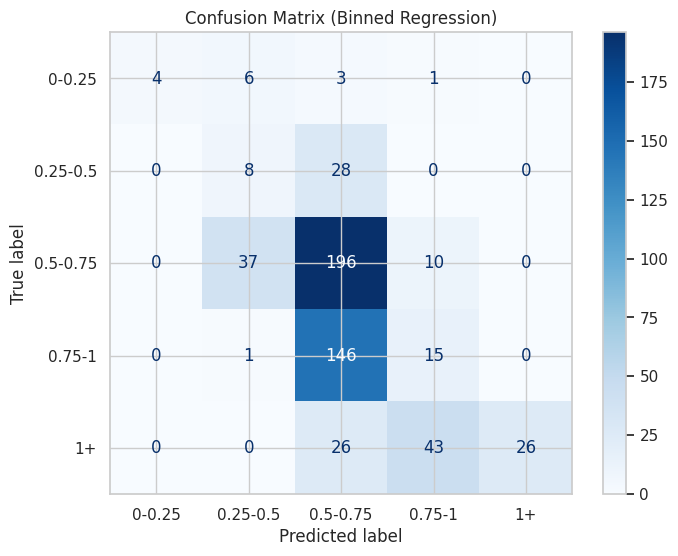

Confusion Matrix:
[[  4   6   3   1   0]
 [  0   8  28   0   0]
 [  0  37 196  10   0]
 [  0   1 146  15   0]
 [  0   0  26  43  26]]


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Example of loading your trained model (adjust as needed)
model = SentimentModel()  # Ensure this matches your saved model architecture
model.load_state_dict(torch.load("model/only_emoji_NN_200.pth", 
                                 map_location=torch.device("cpu"), 
                                 weights_only=True))  # ✅ Fix here
model.eval()  # Set model to evaluation mode

# Lists to store true labels & predictions
y_true, y_pred = [], []

# Disable gradient calculations for inference
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()  # Forward pass
        y_true.extend(y_batch.numpy())  # Store true values
        y_pred.extend(outputs.numpy())  # Store predictions

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Define the bins for discretizing continuous values
bins = [0, 0.25, 0.5, 0.75, 1, 1.5]  # Example bins with an extra bin for values > 1
bin_labels = ["0-0.25", "0.25-0.5", "0.5-0.75", "0.75-1", "1+"]  # Adjusted bin labels

# Bin the continuous true and predicted values
y_true_binned = np.digitize(y_true, bins) - 1  # Subtract 1 to align the bins with labels
y_pred_binned = np.digitize(y_pred, bins) - 1  # Same binning for predicted values

# Compute confusion matrix for binned values
cm = confusion_matrix(y_true_binned, y_pred_binned)

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bin_labels)
disp.plot(cmap="Blues", ax=ax)
plt.title('Confusion Matrix (Binned Regression)')
plt.savefig('binned_confusion_matrix.png')  # Save as an image
plt.show()

# Optional: Print the confusion matrix to the console
print(f"Confusion Matrix:\n{cm}")


# RF AND LGBM

In [19]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
import numpy as np

# Load pre-trained models
rf_model = joblib.load("model/only_emoji_RFR.pkl")
lgbm_model = joblib.load("model/only_emoji_LGBM.pkl")

# Make predictions
rf_pred = rf_model.predict(X_test)
lgbm_pred = lgbm_model.predict(X_test)

# Compute metrics for each model
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n🔹 {model_name} Evaluation:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Generate confusion matrix by binning continuous predictions
    bins = np.linspace(min(y_true), max(y_true), 5)  # 5 bins (adjust if necessary)
    y_true_binned = np.digitize(y_true, bins)  # Bin true values
    y_pred_binned = np.digitize(y_pred, bins)  # Bin predicted values
    cm = confusion_matrix(y_true_binned, y_pred_binned)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=range(1, len(bins)), yticklabels=range(1, len(bins)))
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.close()
    
    return mae, mse, r2

# Evaluate Random Forest and LightGBM separately
metrics_rf = evaluate_model(y_true, rf_pred, "Random Forest")
metrics_lgbm = evaluate_model(y_true, lgbm_pred, "LightGBM")

# Plotting bar chart for Random Forest performance metrics
models_rf = ['Random Forest']
mae_rf = [metrics_rf[0]]
mse_rf = [metrics_rf[1]]
r2_rf = [metrics_rf[2]]

# Create a DataFrame for easy plotting
metrics_rf_values = np.array([mae_rf, mse_rf, r2_rf])

# Bar plot for Random Forest
fig_rf, ax_rf = plt.subplots(figsize=(8, 6))
bar_width = 0.25
index_rf = np.arange(len(models_rf))

bar1_rf = ax_rf.bar(index_rf, metrics_rf_values[0], bar_width, label='MAE')
bar2_rf = ax_rf.bar(index_rf + bar_width, metrics_rf_values[1], bar_width, label='MSE')
bar3_rf = ax_rf.bar(index_rf + 2 * bar_width, metrics_rf_values[2], bar_width, label='R² Score')

ax_rf.set_xlabel('Models')
ax_rf.set_ylabel('Scores')
ax_rf.set_title('Random Forest Performance Metrics')
ax_rf.set_xticks(index_rf + bar_width)
ax_rf.set_xticklabels(models_rf)
ax_rf.legend()

plt.tight_layout()
plt.savefig("Random_Forest_performance_metrics.png")
plt.close()

# Plotting bar chart for LightGBM performance metrics
models_lgbm = ['LightGBM']
mae_lgbm = [metrics_lgbm[0]]
mse_lgbm = [metrics_lgbm[1]]
r2_lgbm = [metrics_lgbm[2]]

# Create a DataFrame for easy plotting
metrics_lgbm_values = np.array([mae_lgbm, mse_lgbm, r2_lgbm])

# Bar plot for LightGBM
fig_lgbm, ax_lgbm = plt.subplots(figsize=(8, 6))
bar1_lgbm = ax_lgbm.bar(index_rf, metrics_lgbm_values[0], bar_width, label='MAE')
bar2_lgbm = ax_lgbm.bar(index_rf + bar_width, metrics_lgbm_values[1], bar_width, label='MSE')
bar3_lgbm = ax_lgbm.bar(index_rf + 2 * bar_width, metrics_lgbm_values[2], bar_width, label='R² Score')

ax_lgbm.set_xlabel('Models')
ax_lgbm.set_ylabel('Scores')
ax_lgbm.set_title('LightGBM Performance Metrics')
ax_lgbm.set_xticks(index_rf + bar_width)
ax_lgbm.set_xticklabels(models_lgbm)
ax_lgbm.legend()

plt.tight_layout()
plt.savefig("LightGBM_performance_metrics.png")
plt.close()



🔹 Random Forest Evaluation:
MAE: 0.1475
MSE: 0.0354
R² Score: 0.3551

🔹 LightGBM Evaluation:
MAE: 0.1410
MSE: 0.0332
R² Score: 0.3961


# ensemble 
# rf, lgbm, xgb

In [11]:
import joblib

# Load ensemble model
ensemble_model = joblib.load("model/only_emoji_ensemble.pkl")


In [13]:
print(type(ensemble_model))
print(ensemble_model)  # Print the actual content


<class 'tuple'>
(RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42), LGBMRegressor(max_depth=5, random_state=42), XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...))


In [14]:
import joblib

# Load the tuple file
rf_model, lgbm_model, xgb_model = joblib.load("model/ensemble_tuple.pkl")

# Verify models are loaded correctly
print(type(rf_model))  # Should be <class 'sklearn.ensemble._forest.RandomForestRegressor'>
print(type(lgbm_model))  # Should be <class 'lightgbm.sklearn.LGBMRegressor'>
print(type(xgb_model))  # Should be <class 'xgboost.sklearn.XGBRegressor'>


<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>


In [15]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge  # Meta-model

# Define stacking ensemble
stacking_ensemble = StackingRegressor(
    estimators=[
        ("rf", rf_model), 
        ("lgbm", lgbm_model), 
        ("xgb", xgb_model)
    ],
    final_estimator=Ridge(),  # Meta-model to combine predictions
    passthrough=True
)

# Train the ensemble
stacking_ensemble.fit(X_train, y_train)

# Save new ensemble model
joblib.dump(stacking_ensemble, "stacking_ensemble.pkl")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2200, number of used features: 300
[LightGBM] [Info] Start training from score 0.638068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

['stacking_ensemble.pkl']

In [16]:
# Load model
ensemble_model = joblib.load("model/stacking_ensemble.pkl")  # or "voting_ensemble.pkl"

# Predict
y_pred = ensemble_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("🔹 Ensemble Model Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")


🔹 Ensemble Model Performance:
MAE: 0.1382
MSE: 0.0316
R² Score: 0.4250


In [20]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
import numpy as np

# Load model
ensemble_model = joblib.load("model/stacking_ensemble.pkl")  # or "voting_ensemble.pkl"

# Predict
y_pred = ensemble_model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation
print("🔹 Ensemble Model Performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot and save performance metrics graph
metrics = ['MAE', 'MSE', 'R² Score']
scores = [mae, mse, r2]

# Create a bar plot for the performance metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['blue', 'green', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Ensemble Model Performance Metrics')

# Save the plot as a .png file
plt.tight_layout()
plt.savefig("ensemble_model_performance_metrics.png")
plt.close()

# Generate confusion matrix by binning continuous predictions
bins = np.linspace(min(y_test), max(y_test), 5)  # 5 bins (adjust if necessary)
y_true_binned = np.digitize(y_test, bins)  # Bin true values
y_pred_binned = np.digitize(y_pred, bins)  # Bin predicted values
cm = confusion_matrix(y_true_binned, y_pred_binned)

# Plot and save the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=range(1, len(bins)), yticklabels=range(1, len(bins)))
plt.title("Confusion Matrix: Ensemble Model")
plt.xlabel('Predicted')
plt.ylabel('True')

# Save confusion matrix as a .png file
plt.tight_layout()
plt.savefig("ensemble_model_confusion_matrix.png")
plt.close()

# Optional: Display the confusion matrix plot
# plt.show()


🔹 Ensemble Model Performance:
MAE: 0.1382
MSE: 0.0316
R² Score: 0.4250


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define model performance metrics
data = {
    "Model": ["Random Forest", "LightGBM", "Neural Network", "Ensemble Model"],
    "MAE": [0.1475, 0.1410, 0.1406, 0.1382],
    "MSE": [0.0354, 0.0332, 0.0326, 0.0316],
    "R²": [0.3551, 0.3961, 0.4065, 0.4250],
    "Accuracy": [85.25, 85.90, 85.94, 86.18]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Define function to generate and save plots
def plot_and_save(metric, ylabel, filename):
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x="Model", y=metric, data=df, palette="coolwarm", edgecolor="black")
    plt.xlabel("Model", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f"{metric} Comparison", fontsize=14, fontweight="bold")
    
    # Display values on bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, fontweight="bold")

    plt.xticks(rotation=20)
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.close()

# Generate and save all graphs
plot_and_save("MAE", "Mean Absolute Error (Lower is Better)", "mae_comparison")
plot_and_save("MSE", "Mean Squared Error (Lower is Better)", "mse_comparison")
plot_and_save("R²", "R² Score (Higher is Better)", "r2_comparison")
plot_and_save("Accuracy", "Accuracy (%) (Higher is Better)", "accuracy_comparison")

print("Graphs saved successfully as PNG files.")


/tmp/ipykernel_640504/2286379110.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y=metric, data=df, palette="coolwarm", edgecolor="black")
/tmp/ipykernel_640504/2286379110.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y=metric, data=df, palette="coolwarm", edgecolor="black")
/tmp/ipykernel_640504/2286379110.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y=metric, data=df, palette="coolwarm", edgecolor="black")
/tmp/ipykernel_640504/2286379110.py:24: FutureWarning: 

Passing `p

Graphs saved successfully as PNG files.
